# SSD : Single Shot MultiBox Detector

## 1. Introduction

- 1-stage detector인 YOLO는 45 frames per second(FPS)로 7 FPS인 Faster R-CNN보다 **속도가 크게 향상**되었지만 <br>
YOLO mAP : 63.4%과 Faster R-CNN : mAP 74.3% 비교했을때 **정확도가 낮다**는것을 알 수 있다. 이를 개선하기위해 만든것이 SSD이다.
> 2-stage detector인 Faster R-CNN의 정확도와 1-stage detector의 성능을 가지는 모델
- 논문의 저자들이 요약한 **contribution**은 다음과 같다.
> 1) 작은 convolutional filter들을 사용하여 feature map에 적용해 <br>
고정된 default bounding boxes의 category score 및 box offset을 예측하는 것이다. <br>
> 2) detection의 높은 정확도를 얻기 위해 다양한 크기(scale)의 feature map에서 다양한 크기(scale)의 prediction을 생성하고, aspect ratio(종횡비)별로 예측을 구분한다. <br>
> 3) 이러한 design feature들은 저해상도 input image에서도 간단한 end-to-end training과 높은 정확도로 이어져, <br>
속도와 정확도의 trade-off를 더욱 개선한다.



## 2. Core concepts
> 논문에서 소개되는 주요 개념들은 다음과 같다.
>> Default boxes and aspect ratios, Matching strategy, Loss function

### 2-1. Default boxes and aspect ratios


<img src='https://drive.google.com/uc?export=download&id=13IMXvtsxlI66dNIfITPfTlg-Nkoyr-jH' height="400" width="750">

- 모델에서 각 feature map들마다 bounding box regression과 object detection을 수행하기 위해 해당 feature map에 3x3 convolution을 하게된다. <br> 
> SSD에서는 이때 Faster-RCNN 에서 region proposal을 위해 사용했던 앵커(Anchor)박스와 유사한 개념인 **default box**를 사용하게 된다. <br>
- 미리 박스를 만들어주지않고 바로 예측하는 YOLO와 다르게 이것은 성능을 향상시켜주는 요인이 된다. <br>
- 각 feature map마다 어떻게 몇개의 bounding box를 뽑는지에 대해 살펴보자. <br>
> 논문에서는 각 feature map에 차례대로 4개,6개,6개,6개,4개,4개의 default box들을 먼저 선정했다. 


<center><img src='https://drive.google.com/uc?export=download&id=1ccmUxcdZQEEW8DWiJJD8ZLmr1kgi3-B7' height="300" width="900"> </center>

> - 그 중 두번째의 19x19 Con7 피쳐맵에 대해서 bounding box를 생성하는 과정을 하나의 예제로 살펴보면 <br> 
이 feature map에서는 6개의 default bounding box를 만들고 이 박스와 대응되는 자리에서 <br>
예측되는 박스의 offset과 class score를 예측한다. <br> 
이것을 선정한 default box의 갯수만큼 반복하여 다양한 object를 찾아낸다. 즉,<br>
>> __6(default box) X (20개:Classes-PASCAL VOC기준 + 1:object인지 아닌지)=21+4(offset 좌표)) = 150(ch)__ <br>
이것이 default boxes(바운딩박스들)이 담고있는 정보이다.

<center> <img src='https://drive.google.com/uc?export=download&id=1DBgcAatbTaqWlvll6BVHDflVCgaXVCDe' height="470" width="900"> </center>

> 이를 모든 feature map 6개의 로케이션에 대해서 뽑아내면 논문에서 소개된 <br>
38x38x4 + 19x19x6 + 10x10x6 + 5x5x6 + 3x3x4 + 1x1x4 <br>
= 총 8732개의 바운딩박스를 뽑는 과정이다. <br>

#### + Matching strategy

<center><img src='https://drive.google.com/uc?export=download&id=1hGSSbx6ikjomTeV8Vkw8rCe9cWpKH7ST' height="500" width="1000"></center>

- 훈련을 위해 이와 같이 뽑은 bounding boxes(predicted boxes)은 그대로 모두 사용하지않고 <br> 
각각을 Ground truth box들과 비교하여 선별하는데 이것들을 매칭하는 전략은 다음과 같다. <br>
> 1. jaccard index(IoU)로 Ground truth와 가장 많이 overlap되는 default box들을 ground truth box 하나당 한개씩 먼저 뽑는다.
> 2. jaccard index(IoU) thredhold 0.5 이상이 되는 default box들을 뽑는다. 

- 이렇게 뽑은 가능성있는 박스들은 Non-Max suppression을 통해 걸러주고
최종적으로 나온 박스를 regression 훈련에 사용하게 된다.

### 2-2. Choosing scales and aspect ratios for default boxes

<img src='https://drive.google.com/uc?export=download&id=1Ia8aFNp1HtWIQ1lf1znK4eNN-lUxpl0u' height="300" width="750">

- SSD에서 다양한 레이어의 피쳐맵들을 사용하는것은 scale variance를 다룰 수 있다. <br>
- bounding box를 찾는데에 있어 위의 그림처럼 8x8의 feature map에서는 default box가 <br> 
상대적으로 작은 물체(고양이)를 찾는데에 높은 IoU가 매칭될 것이고, <br> 
4x4 feature map에서는 상대적으로 큰 물체(강아지)에게 매칭 될 것이다. <br>
> **즉 앞쪽에 resolution이 큰 feature map에서는 작은 물체를 감지하고, <br>
뒤쪽에 resolution이 작은 feature map에서는 큰 물체를 감지할 수 있다**는 것이 <br>
multiple feature map 사용의 메인 아이디어이다. <br>

- 그렇다면 default boxes들은 어떻게 다양하게 만들어주는지 살펴볼 수 있다.


> $S_k = S_{min} + \frac{S_{max} - S_{min}}{m-1}(k-1), k ∈[1,m]$ <br>
> $ S_{min} = 0.2, S_{max} = 0.9 $
* $S_k$ = scale
* $m$ = feature map의 갯수
* $k$ = feature map index

- 위의 식으로 m개의 feature map에서 bounding box를 뽑아낸다. <br>
- 각 k값을 차례대로 넣어보면 PASCAL VOC 기준으로 <br>
$S_k = 0.1, 0.2, 0.375, 0.55, 0.725, 0.9$
라는 scale을 얻을 수 있다. <br>
> $S_0 = 0.1$ (chapter3.1의 PASCAL VOC 2007에서 conv4_3의 scale을 0.1로 setting)

- 이것은 전체 Input 이미지에서의 각 비율을 의미한다. <br>
> 즉 Input이 300x300 이미지이기 때문에 0.1은 30픽셀, 0.2는 60픽셀,각각 <br>
$ 30,60,112.5,165,217.5,270 pixels $ <br>
이와 같이 인풋 이미지를 대변한다. <br>

- 이렇게 scale이 정해지면 아래의 식으로 default box(bounding box)의 크기가 정해진다. <br>
> $a_r ∈$ {$1,2,3,\frac{1}{2},\frac{1}{3} $} <br>
$w^a_k = S_k \sqrt{a_r} $ <br>
$h^a_k = S_k /\sqrt{a_r} $ <br><br>

- 각각의 scale을 대입해주면 해당 default box의 크기를 구할 수 있다.
> 예외적으로 feature map 6개를 뽑을때 ratio=1인 하나의 default box에 대해선 <br>
$S'_k = \sqrt{S_kS_k+1}$ <br>
로 새로운 scale을 추가해준다. <br><br>


* 아래의 식으로 default box의 중심점을 구할 수 있다.
> $(\displaystyle \frac{i+0.5}{|f_k|},\frac{j+0.5}{|f_k|})$ <br>
$|f_k|$ = k번째 feature map의 가로세로 크기 , $i,j ∈ [0,|f_k|]$ <br>


<img src='https://drive.google.com/uc?export=download&id=1lw5j-qzf7cch7-GTpVDNpRl3W_OO22h2' height="250" width="700">


### 2-3. Loss function
- training 목표 : mutiple object detection

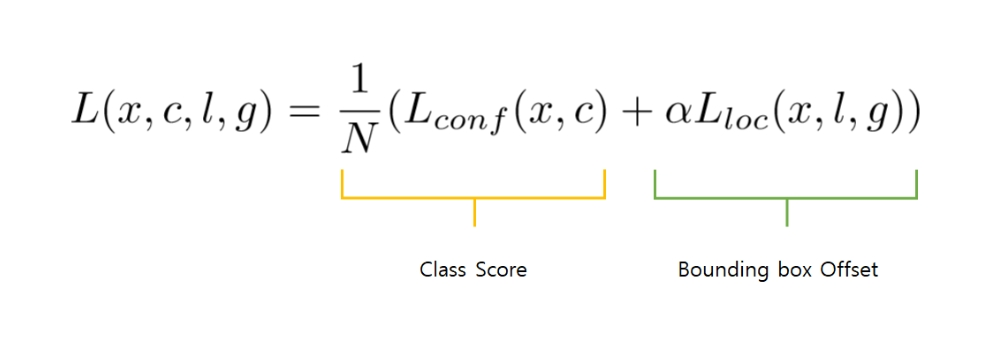

#### 0) **SSD training 목표는 MultiBox에서 파생되었으나, multiple object categories를 다루는것이 확장되었다.**
- MultiBox의 Loss식은 다음과 같다.
> $F_{conf}(x,c)=-\displaystyle\sum_{i,j}x_{ij}log(c_i)-\displaystyle\sum_{i}(1-\displaystyle\sum_jx_{ij})log(1-c_i)$
> - binary loss와 유사
> - $x_{ij} = $1 or 0
> - **하나의 box만 가져와서** $\sum x_{ij}=1$이지만
- SSD는 IoU가 가장 높은 box뿐만 아니라 <br>
jaccard overlap(중복되는 부분)이 **thredhold(0.5)이상이면 모두 default box들**로 보기때문에 $\sum x^{p}_{ij}\geq1$이 된다.
> 그래서 전체 loss에서 default box들의 개수인 **$N$으로 나눠주는 이유**이다.

#### 1) $L_{conf}(x,c)$(cross entropy)

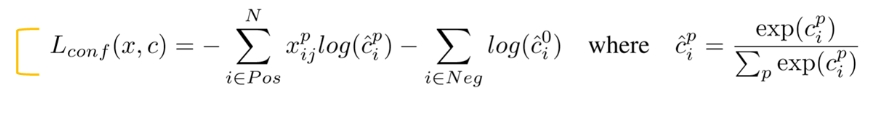

- $x^p$$_{ij}$값은 물체의 j번째 ground truth와 i번째 default box간의 IOU가 0.5 이상이면 1, 0.5미만이면 0을 대입해준다. <br>
따라서 물체의 j번째 ground truth와 i번째 default box 간의 IOU가0.5 미만인 default box는 식에서 0이 되어 사라지게된다.

**$\Rightarrow$ 너무많은 default box가 있다. 그래서 back ground를 가리키고 있는  default box를 날려서 default box의 수를 최소화하는 작업이다.**

#### 2) $L_{loc}(x,l,g)$

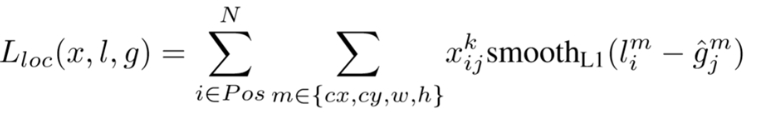

- $ g $ : **ground truth box**
> $\hat{g}_{j}^{cx}$= (${g}_{j}^{cx}$-${d}_{i}^{cx}$) / ${d}_{i}^{w}$,<br>
$\hat{g}_{j}^{cy}$= (${g}_{j}^{cy}$-${d}_{i}^{cy}$) / ${d}_{i}^{h}$,<br> 
$\hat{g}_{j}^{w}$ = $log({g}_{j}^{w}/{d}_{i}^{w}), $ <br> 
$\hat{g}_{j}^{h}$ = $log({g}_{j}^{h}/{d}_{i}^{h})$


- $ l $ : **prediction box**
> $\hat{l}_{i}^{cx}$= (${l}_{i}^{cx}$-${d}_{i}^{cx}$) / ${d}_{i}^{w}$,<br>
$\hat{l}_{i}^{cy}$= (${l}_{i}^{cy}$-${d}_{i}^{cy}$) /  ${d}_{i}^{h}$,<br> 
$\hat{l}_{i}^{w}$ = $log({l}_{i}^{w}$/${d}_{i}^{w}$),<br>
$\hat{l}_{i}^{h}$ = $log({l}_{i}^{h}$/${d}_{i}^{h}$)


-  $ L_{reg} $ : **regression loss(smooth $ L_1 $)** 
> $ L_{reg}$( $\hat{l}_{i}^{m}$,$\hat{g}_{j}^{m}$) = R($\hat{l}_{i}^{m}$,$\hat{g}_{j}^{m}$) , $R$ : the rubust loss function (smooth $ L_1 $)<br>
> $ = L_1$($\hat{l}_{i}^{cx}$-$\hat{g}_{j}^{cx}$)$ + L_1$($\hat{l}_{i}^{cy}$-$\hat{g}_{j}^{cy}$)+  $L_1$(log($\hat{l}_{i}^{w}$)-(log($\hat{g}_{j}^{w}$ ))+$L_1$(log($\hat{l}_{i}^{h}$)-log($\hat{g}_{j}^{h}$ ))

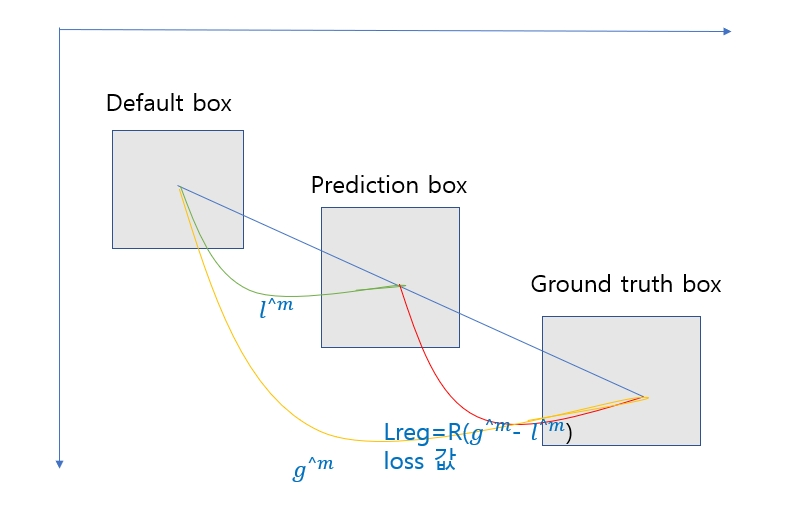

#### 3) $L_{loc}$(x,l,g)식에 나오는 용어정리
* N : ground truth와 매치된 default box의 개수
* l : predicted box (예측된 상자)
* g : ground truth box
* d : default box
* cx, cy : 그 박스의 x, y좌표
* w, h : 그 박스의 width, heigth
* $\alpha$ 에는 1을 대입해준다. 
* ground truth 와 default box의 IOU값이 0.5이상인것만 고려한다.<br>
=background object인 negative sample 에 대해서는 Localization Loss를 계산하지 않는다.


## 3. Hard negative mining

- 사실 매칭 스텝 후에 생성된 대부분의 default boxes(bounding boxes)은 object가 없는 background이다. <br>
이것은 Faster R-CNN에서도 대두되었던 문제인데 negative인, 즉 background들을 사용해 트레이닝하는것은 모델에 도움이 되지않는다. <br>
Faster R-CNN에서는 256개의 미니배치에서 128개의 positive, 128개의 negative를 사용해서 훈련하도록 권고했으나 <br> 
negative가 너무 많으면 이 비율은 어쩔수없이 유지하기 힘들다. <br>
> SDD에서는 이러한 positive와 negative의 inbalance문제에 대해 confidence loss가 높은 negative값들을 뽑아 <br> 
> **positive와 negative를 1:3 비율**로 사용하길 제안했다. 이것으로 더 빠른 최적화와 안정적인 트레이닝을 이끌었다.


## 4. Data augmentation
- 전체 원본 input 이미지를 사용한다.
- object와 jaccard IoU가 최소인 0.1, 0.3, 0.5, 0.7, 0.9이 되도록 패치를 샘플링한다.
- 랜덤하게 패치를 샘플링한다.
> 샘플링시 $\frac{1}{2}$와 $2$사이로 랜덤하게 정한다.

## 5. Experimental Results

### 5-1. Base Network
- 논문에서의 실험은 모두 **VGG16**을 기반으로 train하는데 layer를 다음과 같이  수정한다. <br>

<img src='https://drive.google.com/uc?export=download&id=1t550Gj4iQvYho2AuXBbsmCfXeK_5Ken5' height="400" width="1000">


1. VGG16 내 full connected layer 6,7을 subsampling parameter를 생성하는 **convolutional layer**로 변환한다.
2. pool5 layer(linear)를 $2$x$2$-s2, $3$x$3$-s1의 *atrous 알고리즘*을 사용하여 pool5 layer를 바꾼다.
> 일반 VGG16을 사용하는 경우 pool5를 2×2-s2 fc6 및 fc7의 subsampling parameter가 아니라 예측을 위해 conv5 3을 추가하면 결과는 거의 같지만 속도는 약 20% 느려진다.<br>
> **즉, *atrous 알고리즘*이 더 빠르다.**
3. drop out과 full connected layer 8을 없앤다.


#### + *A'trous 알고리즘 (dilated convolution)* <br>
<img src='https://drive.google.com/uc?export=download&id=12ey06VHMA4uSykBaIyXRDmDmPUJ-tVeJ' height="300" width="300"> <br>
- 기존 컨볼루션 필터가 수용하는 픽셀 사이에 간격을 둔 형태이다. <br>
입력 픽셀 수는 동일하지만, 더 넓은 범위에 대한 입력을 수용할 수 있게 된다.
- 즉, convolutional layer에 또 다른 parameter인 **dilation rate**를 도입했다.<br> 
> dilation rate는 **커널 사이의 간격**을 정의한다. <br>
> dilation rate가 2인 3x3 커널은 9개의 parameter를 사용하면서, 5x5 커널과 동일한 view를 가지게 된다.
- 적은 계산 비용으로 Receptive Field 를 늘리는 방법이라고 할 수 있다. <br>
이 A'trous 알고리즘은 필터 내부에 zero padding 을 추가해서 강제로 Receptive Field 를 늘리게 되는데, <br>
위 그림에서 진한 파란색 부분만 weight가 있고 나머지 부분은 0으로 채워지게 된다. <br>
이 Receptive Field는 필터가 한번 보는 영역으로 사진의 Feature를 파악하고, 추출하기 위해서는 넓은 Receptive Field 를 사용하는 것이 좋다. <br>
dimension 손실이 적고, 대부분의 weight가 0이기 때문에 연산의 효율이 좋다. <br>
공간적 특징을 유지하는 Segmentation에서 주로 사용되는 이유이다. 

#### + Classifier : Conv 3X3X(4X(classes+4))가 나오는 이유,방식
> * **same conv 연산**하기때문
<img src='https://drive.google.com/uc?export=download&id=1JBAXfe-lbOpO_IzBRAXlA7_pHvfiVKWZ' height="300" width="750">
> * 결과 : 38x38x(4X(classes+4)) <br>
> * 19x19x(6X(classes+4)), 10x10x(6X(classes+4)), 5x5x(6X(classes+4)), <br>
3x3x(4X(classes+4)), 1x1x(4X(classes+4))도 위와 같은 방식

### 5-2. More default box shapes is better.
>- 기본적으로 6개의 default box를 사용하지만 aspect ratio=$\displaystyle \frac{1}{3}, 3$을 제거하면 성능이 0.6% 감소한다.
>- 다양한 default box shape을 사용하면 네트워크에서 box를 예측
하는 작업이 더 쉬워진다는 것을 알 수 있다.

## 6. Conclusions
- 핵심은 top layer에서 multiple feature map이 연결된 다양한 크기의 convolutional bounding box를 출력한다는 것이다.
- 가능한 box shape의 공간을 효율적으로 모델링할 수 있다.
> 단점 : 작은 feature map에서 큰 object만 detection한다.

---
Reference

[참고1](https://csm-kr.tistory.com/4)
[참고2:atrous algorithm](https://eehoeskrap.tistory.com/431)

[paper](https://arxiv.org/pdf/1512.02325.pdf) 
[1](https://csm-kr.tistory.com/4) 
[2](https://eehoeskrap.tistory.com/431) 
[3](http://www.okzartpedia.com/wordpress/index.php/2020/07/16/ssd-single-shot-detector/) 
[4](https://ys-cs17.tistory.com/12)